### 📓 **Data Preprocessing Notebook – Unified Dataset Support**

This notebook handles the initial preparation and validation of datasets used for binary fire classification. It now supports **four** dataset types through a unified preprocessing pipeline:

- 🔥 **Real-world outdoor dataset (D-Fire)**  
- 🧪 **Synthetic outdoor dataset (MSFFD / Yunnan University)**  
- 🏠 **Real-world indoor dataset (PLOS ONE / Indoor-FS)**  
- 🧯 **Synthetic indoor dataset (SYN-FIRE, mask-based)**

The notebook performs the following steps:

- Lets you select which dataset type to use (`real`, `synthetic`, `plos`, or `syn_fire`)  
- Sets the appropriate file paths to images and labels/masks stored in Google Drive  
- Uses the refactored loaders:  
  - `FireClassificationDataset` (YOLO → binary label) for **D-Fire**, **Yunnan**, **PLOS ONE**  
  - `FireClassificationMaskDataset` (mask → binary label) for **SYN-FIRE**  
- Applies torchvision transforms (e.g., resizing and tensor conversion)  
- Instantiates the dataset and verifies image–label logic  
- Optionally previews sample images (and masks for SYN-FIRE) to ensure correctness

> Mixed-ratio training remains supported via `FireClassificationMixedDataset` (handled in training notebooks, not here).

This preprocessing step ensures that the dataset pipeline is correctly configured and that labels are properly interpreted before evaluation or training.


### 📦 Notebook Setup: Mount Drive & Clone GitHub Repo

This cell ensures the notebook is ready to run by:

- Mounting your Google Drive (where your token is stored)  
- Loading your GitHub token from Drive  
- Cloning the project repository into the Colab VM (fresh each time)  
- Navigating into the cloned repo  
- Setting Git credentials to enable committing changes if needed

> ⚠️ **Note**: This cell must be run every time you open this notebook in a new Colab session.


In [1]:
# 🔁 Minimal Colab setup for any working notebook

# 1. Mount Google Drive
import os
from google.colab import drive
if not os.path.ismount("/content/drive"):
    drive.mount("/content/drive")

# 2. Load GitHub token securely from Drive
token_path = "/content/drive/MyDrive/fire-detection-dissertation/secrets/github_token.txt"
with open(token_path, "r") as f:
    token = f.read().strip()

# 3. Clone the GitHub repo (force fresh clone for safety)
username = "Misharasapu"
repo = "fire-detection-dissertation"
clone_url = f"https://{token}@github.com/{username}/{repo}.git"
repo_path = f"/content/{repo}"

# Optional: Remove old clone (safe to rerun)
!rm -rf {repo_path}

# Clone fresh and move into the repo
%cd /content
!git clone {clone_url}
%cd {repo}

# 4. Set Git identity (required in Colab sessions)
!git config --global user.name "Misharasapu"
!git config --global user.email "misharasapu@gmail.com"


Mounted at /content/drive
/content
Cloning into 'fire-detection-dissertation'...
remote: Enumerating objects: 120, done.
remote: Counting objects: 100% (120/120), done.
remote: Compressing objects: 100% (92/92), done.
remote: Total 120 (delta 56), reused 86 (delta 26), pack-reused 0 (from 0)
Receiving objects: 100% (120/120), 4.25 MiB | 12.33 MiB/s, done.
Resolving deltas: 100% (56/56), done.
/content/fire-detection-dissertation


### 🗂️ Step 1 – Define Dataset Mode and File Paths

In this step, we define which dataset to preprocess — one of the following:

- **D-Fire (real-world outdoor dataset)**  
- **MSFFD (synthetic outdoor dataset by Yunnan University)**  
- **PLOS ONE (real-world indoor dataset)**  
- **SYN-FIRE (synthetic indoor dataset with segmentation masks)**

We then set the appropriate paths stored in Google Drive.  
The selected dataset mode is passed into the **correct loader** with the required label logic:

- `dataset_mode = "real"` → **D-Fire** via `FireClassificationDataset` (YOLO; **class 1 = fire**)  
- `dataset_mode = "synthetic"` → **Yunnan** via `FireClassificationDataset` (YOLO; **class 0 = fire**)  
- `dataset_mode = "plos"` → **PLOS ONE** via `FireClassificationDataset` (YOLO; **class 0 = fire**)  
- `dataset_mode = "syn_fire"` → **SYN-FIRE** via `FireClassificationMaskDataset` (mask; **any white pixel = fire**)

---

**Requirements**

- **YOLO datasets (D-Fire, Yunnan, PLOS ONE):**  
  - Images in `.jpg`  
  - Labels as matching `.txt` files in YOLO format (`<class> <x_center> <y_center> <width> <height>`)  
  - Correct `dataset_mode` to ensure the right class→binary mapping

- **Mask dataset (SYN-FIRE):**  
  - Images in `.png` (RGB), masks in `.png` (binary/greyscale)  
  - Image and mask share the same filename stem (e.g., `000123.png`)  
  - Binary label rule: **label = 1** if mask has any non-zero pixel; otherwise **0**

This step ensures the preprocessing pipeline loads the correct images and label source before training or evaluation.


In [11]:
# 🔧 Choose dataset_mode: 'real', 'synthetic', 'plos', or 'syn_fire'
dataset_mode = "synthetic"  # change to 'real' | 'synthetic' | 'plos' | 'syn_fire' as needed

# 📁 Define paths based on selected dataset
if dataset_mode == "real":
    image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/train/images"
    label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/train/labels"
    mask_dir  = None

elif dataset_mode == "synthetic":
    image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/synthetic/yunnan/synthetic_all/images"
    label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/synthetic/yunnan/synthetic_all/labels"
    mask_dir  = None

elif dataset_mode == "plos":
    image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/PLOS_ONE/train/images"
    label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/PLOS_ONE/train/labels"
    mask_dir  = None

elif dataset_mode == "syn_fire":
    image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/synthetic/syn-fire/synthetic_all/images"
    mask_dir  = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/synthetic/syn-fire/synthetic_all/masks"
    label_dir = None  # not used for mask-based loader

else:
    raise ValueError("❌ Invalid dataset_mode. Choose 'real', 'synthetic', 'plos', or 'syn_fire'.")

print(f"✅ Mode: {dataset_mode}")
print(f"📁 Image directory: {image_dir}")
if label_dir: print(f"📄 Label directory: {label_dir}")
if mask_dir:  print(f"🩹 Mask directory : {mask_dir}")


✅ Mode: synthetic
📁 Image directory: /content/drive/MyDrive/fire-detection-dissertation/data/raw/synthetic/yunnan/synthetic_all/images
📄 Label directory: /content/drive/MyDrive/fire-detection-dissertation/data/raw/synthetic/yunnan/synthetic_all/labels


### 🔧 Step 2 – Import Dataset Classes and Define Image Transformations

In this step, we import the dataset loaders and define a consistent transform pipeline.

**Loaders used:**
- `FireClassificationDataset` → unified loader for **YOLO-labelled** datasets (D-Fire, Yunnan/MSFFD, PLOS ONE).  
  - Handles the different class mappings via `dataset_type` internally.
- `FireClassificationMaskDataset` → loader for **mask-labelled** datasets (SYN-FIRE).  
  - Derives image-level labels directly from segmentation masks.
- `FireClassificationMixedDataset` → **training-only** mixed real/synthetic sampler (not used in this preprocessing notebook).

**Transforms (applied on-the-fly):**
- 🔁 **Resize** to `224×224` for ResNet-50 compatibility  
- 📥 **ToTensor** to convert PIL images to PyTorch tensors  
- 🔢 **Normalization** (optional at this stage — can be applied in training/eval notebooks)

These transforms ensure consistent input shape and type across all datasets.


In [12]:
from utils.fire_classification_dataset import (
    FireClassificationDataset,        # YOLO -> binary (D-Fire, PLOS, Yunnan)
    FireClassificationMixedDataset,   # mixed ratios (not used here, but keep import)
    FireClassificationMaskDataset     # NEW: SYN-FIRE masks -> binary
)
from torchvision import transforms

# Common transforms (keep consistent with the rest of your pipeline)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-50 input size
    transforms.ToTensor()
])


### 📦 Step 3 – Create the Dataset Object and Inspect a Sample

We now instantiate the **appropriate dataset class** based on `dataset_mode`:

- `"real"`, `"synthetic"`, or `"plos"` → `FireClassificationDataset` (reads YOLO `.txt`, converts to binary label using the correct class ID rule)  
- `"syn_fire"` → `FireClassificationMaskDataset` (reads paired `.png` mask and converts to binary label using pixel values)

We pass:
- Image directory (and label directory for YOLO **or** mask directory for SYN-FIRE)
- The selected transform pipeline
- For YOLO datasets: `dataset_type` to ensure the correct class→binary mapping  
  - D-Fire: **class 1 → fire (1)**  
  - Yunnan/MSFFD: **class 0 → fire (1)**  
  - PLOS ONE: **class 0 → fire (1)**

This dataset object enables:
- Accessing image–label pairs using indexing (e.g., `image, label = dataset[0]`)  
- On-the-fly transforms (resize, tensor conversion)  
- 🔍 Verifying that **binary labels** are correctly derived from YOLO or mask rules

We’ll preview a sample to confirm:
- ✅ Image tensor shape is `[3, 224, 224]` (channel-first RGB)  
- ✅ Label is a PyTorch integer tensor with value `0` (no fire) or `1` (fire)


In [13]:
# ✅ Create dataset object based on the selected mode
if dataset_mode in {"real", "synthetic", "plos"}:
    # Map dataset_mode directly to the dataset_type arg used by your YOLO loader
    dataset = FireClassificationDataset(
        image_dir=image_dir,
        label_dir=label_dir,
        transform=transform,
        dataset_type=dataset_mode  # "real" | "synthetic" | "plos"
    )
elif dataset_mode == "syn_fire":
    dataset = FireClassificationMaskDataset(
        image_dir=image_dir,
        mask_dir=mask_dir,
        transform=transform
    )
else:
    raise ValueError("Invalid dataset_mode")

# 🔍 Load a sample image-label pair
sample_index = 1000  # change to inspect other samples
image, label = dataset[sample_index]

print("Image shape:", image.shape)  # Expected: [3, 224, 224]
print("Label:", label.item())       # Expected: 0 (no fire) or 1 (fire)


Image shape: torch.Size([3, 224, 224])
Label: 1


### 🖼️ Step 4 – Visualise a Sample Image and Its Binary Label

Now that the dataset is correctly loading image tensors and binary labels, we visually inspect a sample image to verify:

- The image has been read and transformed correctly  
- The shape, orientation, and colours are as expected  
- The binary label (`0` = no fire, `1` = fire) appears consistent with the image

**For SYN-FIRE only:** we also preview the **mask** to confirm the label logic:  
- If the mask contains any white pixel(s), the label should be **1 (fire)**  
- If the mask is fully black, the label should be **0 (no fire)**  
- The mask filename matches the image filename (same stem), ensuring correct pairing

This visual confirmation helps validate the preprocessing pipeline before training.


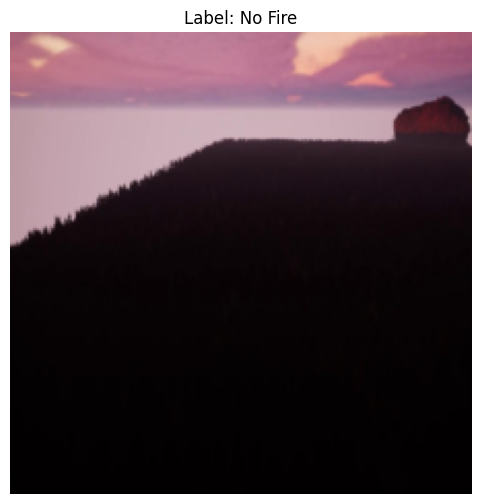

In [15]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# Select an index to preview
index = 2000  # Adjust depending on dataset size
image, label = dataset[index]

# Convert image tensor [C, H, W] to numpy array [H, W, C] for plotting
image_np = image.permute(1, 2, 0)

# Always show the image + label
plt.figure(figsize=(6, 6))
plt.imshow(image_np)
plt.title(f"Label: {'Fire' if label.item() == 1 else 'No Fire'}")
plt.axis('off')
plt.show()

# 🔍 If dataset_mode is syn_fire, also show the mask for verification
if dataset_mode == "syn_fire":
    img_name = dataset.image_files[index]  # filename from dataset list
    mask_path = os.path.join(mask_dir, img_name)

    if os.path.exists(mask_path):
        mask = Image.open(mask_path).convert("L")  # grayscale
        plt.figure(figsize=(6, 6))
        plt.imshow(mask, cmap="gray")
        plt.title("Mask (white = fire)")
        plt.axis('off')
        plt.show()
    else:
        print("⚠️ No mask file found for:", img_name)


### 🚀 Step 5 — Fast Sanity Check (no image loading)

This version skips reading images and only inspects the **label source**:
- For **SYN‑FIRE**: reads mask files and checks if any pixel > 0 (no transforms, no RGB load).
- For **YOLO datasets**: reads `.txt` label files and applies the dataset’s class→binary mapping.

This is much faster on Drive.


In [16]:
import os
from PIL import Image

def fast_count_syn_fire(mask_dir):
    pos = neg = 0
    masks = [f for f in os.listdir(mask_dir) if f.lower().endswith(".png")]
    for m in masks:
        p = os.path.join(mask_dir, m)
        try:
            mx = Image.open(p).convert("L").getextrema()[1]  # (min,max) -> use max
            if mx and mx > 0: pos += 1
            else: neg += 1
        except Exception:
            # If a mask is unreadable, treat as no fire (conservative)
            neg += 1
    return pos, neg, len(masks)

def fast_count_yolo(label_dir, positive_class_ids):
    """
    positive_class_ids: set of ints considered 'fire' for this dataset.
      - D-Fire: {1}
      - Yunnan/MSFFD: {0}
      - PLOS ONE: {0}
    """
    pos = neg = total = 0
    label_files = [f for f in os.listdir(label_dir) if f.lower().endswith(".txt")]
    for lf in label_files:
        fire_found = False
        with open(os.path.join(label_dir, lf), "r") as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                cls = int(parts[0])
                if cls in positive_class_ids:
                    fire_found = True
                    break
        if fire_found: pos += 1
        else:          neg += 1
        total += 1
    return pos, neg, total

# ---- Choose the fast path based on your dataset_mode ----
if dataset_mode == "syn_fire":
    pos, neg, total = fast_count_syn_fire(mask_dir)
    print(f"[SYN-FIRE] Total masks: {total} | Fire(1): {pos} | No Fire(0): {neg} | Fire ratio: {pos/max(1,total):.2%}")

elif dataset_mode == "real":
    pos, neg, total = fast_count_yolo(label_dir, positive_class_ids={1})
    print(f"[D-Fire] Total labels: {total} | Fire(1): {pos} | No Fire(0): {neg} | Fire ratio: {pos/max(1,total):.2%}")

elif dataset_mode == "synthetic":
    pos, neg, total = fast_count_yolo(label_dir, positive_class_ids={0})
    print(f"[Yunnan] Total labels: {total} | Fire(1): {pos} | No Fire(0): {neg} | Fire ratio: {pos/max(1,total):.2%}")

elif dataset_mode == "plos":
    pos, neg, total = fast_count_yolo(label_dir, positive_class_ids={0})
    print(f"[PLOS ONE] Total labels: {total} | Fire(1): {pos} | No Fire(0): {neg} | Fire ratio: {pos/max(1,total):.2%}")

else:
    raise ValueError("Invalid dataset_mode")


[Yunnan] Total labels: 3946 | Fire(1): 3294 | No Fire(0): 652 | Fire ratio: 83.48%


In [ ]:
# Copy the updated notebook from Drive to the repo
!cp /content/drive/MyDrive/fire-detection-dissertation/notebooks/02_data_preprocessing.ipynb /content/fire-detection-dissertation/notebooks/


In [ ]:
%cd /content/fire-detection-dissertation
!git add notebooks/02_data_preprocessing.ipynb
!git commit -m "Refactor preprocessing notebook to support D-Fire, PLOS ONE, and Yunnan datasets using unified dataset class"
!git push


/content/fire-detection-dissertation
[main a9e08bc] Refactor preprocessing notebook to support D-Fire, PLOS ONE, and Yunnan datasets using unified dataset class
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite notebooks/02_data_preprocessing.ipynb (97%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 135.96 KiB | 11.33 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Misharasapu/fire-detection-dissertation.git
   66117e8..a9e08bc  main -> main
